## Util Funs

In [4]:
import numpy as np

### Prospect

In [ ]:


def prospect(x, α, β, λ):
    if x > 0:
        return np.power(x, α)
    else:
        return -λ * np.power(-x, β)


### PLTS

In [5]:

class PLTS:
    def __init__(self, terms, max_scale=7, symmetric_scale=True, weight=1):
        self.terms = terms
        self.max_scale = (
            max_scale  # The maximum scale index used for flipping the scale
        )
        self.symmetric_scale = (
            symmetric_scale  # True if the scale has both positive and negative values
        )
        # self.weight = weight
        self.normalize()

    def normalize(self):
        # total_prob = sum(self.terms.values())
        # self.terms = {scale: prob / total_prob for scale, prob in self.terms.items()}
        # """Normalize the PLTS only if it has more than one element."""
        if len(self.terms) > 1:
            total_prob = sum(self.terms.values())
            if total_prob > 0:
                self.terms = {
                    scale: prob / total_prob for scale, prob in self.terms.items()
                }
            # else:
            # If the total probability is zero, assign a neutral term
            # self.terms = {"s0": 1.0}

    def apply_weight(self, weight):
        """Apply a weight to all scale indices in the PLTS."""
        weighted_terms = {}
        for scale, prob in self.terms.items():
            scale_index = self.extract_scale_index(scale)
            weighted_index = scale_index * weight
            weighted_scale = (
                f"s{weighted_index}"
                if weighted_index >= 0
                else f"s-{abs(weighted_index)}"
            )
            weighted_terms[weighted_scale] = prob
        return PLTS(weighted_terms, self.max_scale, self.symmetric_scale)

    def flip_scale(self, scale):
        # Flip the scale index according to the rules for positive and negative indices
        index = self.extract_scale_index(scale)
        if self.symmetric_scale:
            # For symmetric scales, flip the scale by negating the index
            return "s" + str(0 - index)
        else:
            # For all positive scales, flip the scale within the range
            return "s" + str(self.max_scale - index - 1)

    def extract_scale_index(self, scale):
        """从标度字符串中提取下标，考虑负数情况"""
        if scale.startswith("s-"):
            return float(scale[1:])
        else:
            return float(scale[1:])

    def multiply_with(self, other, weight_factor=1.5):
        """乘法运算，并应用权重因子"""
        combined_terms = self.terms.copy()
        for scale, prob in other.terms.items():
            scale_index = self.extract_scale_index(scale)
            if scale in combined_terms:
                combined_terms[scale] *= prob * weight_factor
            else:
                combined_terms[scale] = prob
        result = PLTS(combined_terms)
        # result.normalize()
        return result

    def add_with(self, other, weight_factor=1):
        """加法运算，并应用权重因子"""
        combined_terms = self.terms.copy()
        for scale, prob in other.terms.items():
            scale_index = self.extract_scale_index(scale)
            if scale in combined_terms:
                # a+b
                # combined_terms[scale] += prob * weight_factor
                # 使用a+b-a*b形式计算概率
                combined_terms[scale] = (
                    combined_terms[scale] + prob - combined_terms[scale] * prob
                )
            else:
                combined_terms[scale] = prob
        result = PLTS(combined_terms)
        # result.normalize()
        return result

    def subtract_with(self, other):
        """Subtract another PLTS from this one."""
        result_terms = self.terms.copy()

        # Subtract matching scales using the a - a*b rule
        for scale, prob in other.terms.items():
            if scale in result_terms:
                result_terms[scale] -= result_terms[scale] * prob
            else:
                # Flip the scale index for non-matching scales
                flipped_scale = self.flip_scale(scale)
                # If the flipped scale is present, subtract from it
                if flipped_scale in result_terms:
                    result_terms[flipped_scale] += prob
                else:
                    # If not, add the flipped scale with a negative probability
                    result_terms[flipped_scale] = prob

        # Normalize the result to remove negative probabilities and ensure the sum is 1
        result_plts = PLTS(result_terms, self.max_scale, self.symmetric_scale)
        result_plts.normalize()
        return result_plts

    def score(self):
        """计算PLTS的加权平均"""
        weighted_sum = sum(
            self.extract_scale_index(scale) * prob for scale, prob in self.terms.items()
        )
        return weighted_sum

    @staticmethod
    def operate_all(plts_list, operation, weight_factor=1.5):
        """对多个PLTS进行操作（乘法或加法）"""
        if not plts_list:
            return PLTS({})

        result = plts_list[0]
        for plts in plts_list[1:]:
            result = operation(result, plts, weight_factor)

        result.normalize()
        return result

    @staticmethod
    def traverse_addition(plts_list):
        """对PLTS的所有元素进行遍历加法，包括语言标度的下标相加"""
        combined_terms = {}
        for i, plts1 in enumerate(plts_list):
            for scale1, prob1 in plts1.terms.items():
                for j, plts2 in enumerate(plts_list):
                    if i != j:  # 确保不与自身组合
                        for scale2, prob2 in plts2.terms.items():
                            scale_index1 = plts1.extract_scale_index(scale1)
                            scale_index2 = plts2.extract_scale_index(scale2)
                            new_scale_index = scale_index1 + scale_index2
                            new_scale = "s" + str(new_scale_index)
                            # combined_terms[new_scale] = (
                            #     combined_terms.get(new_scale, 0) + prob1 + prob2
                            # )
                            # a+b-a*b
                            combined_terms[new_scale] = (
                                combined_terms.get(new_scale, 0)
                                + prob1
                                + prob2
                                - combined_terms.get(new_scale, 0) * (prob1 + prob2)
                            )

        result = PLTS(combined_terms)
        result.normalize()
        return result


### PLTS Evaluation Matrix


In [ ]:

class PLTSEvaluationMatrix:
    def __init__(self, plts_matrix, weights, max_scale=7, symmetric_scale=True):
        self.plts_matrix = (
            plts_matrix  # Matrix of PLTS objects for each scheme and criterion
        )
        self.weights = weights  # Weights for each criterion
        self.max_scale = max_scale  # Maximum scale index
        self.symmetric_scale = (
            symmetric_scale  # Indicates if scales include negative values
        )

    def calculate_SM_for_scheme(self, scheme_plts):
        """Calculate the evaluation matrix for a single scheme according to the formula"""
        num_criteria = len(self.weights)

        scheme_matrix = np.empty((num_criteria, num_criteria), dtype=object)

        score_matrix = np.zeros((num_criteria, num_criteria))

        for j in range(num_criteria):
            for k in range(num_criteria):
                # Calculate the score for each PLTS
                xij_score = scheme_plts[j].score()
                xik_score = scheme_plts[k].score()

                # Calculate the terms based on the given formula
                if j != k:
                    diff = (self.weights[j] * xij_score) - (self.weights[k] * xik_score)
                    # term = f"s{diff}" if diff >= 0 else f"s-{abs(diff)}"
                    if diff >= 0:
                        a1 = scheme_plts[j].apply_weight(self.weights[j])
                        a2 = scheme_plts[k].apply_weight(self.weights[k])
                        scheme_matrix[j][k] = a1.subtract_with(a2)
                    else:
                        # pass
                        scheme_matrix[j][k] = PLTS({"s0": 0})
                else:
                    if xij_score >= 0:
                        # pass
                        scheme_matrix[j][k] = scheme_plts[j]
                    else:
                        # pass
                        scheme_matrix[j][k] = PLTS({"s0": 0})

                scheme_matrix[j][k].normalize()  # Normalize the PLTS in the matrix

        for i in range(num_criteria):
            for j in range(num_criteria):
                score_matrix[i, j] = scheme_matrix[i, j].score()
                # if score_matrix[i, j]:
                #     score_matrix[i, j] = scheme_matrix[i, j].score()
                # else:
                #     score_matrix[i, j] = 0

            return scheme_matrix, score_matrix

    def calculate_IM_for_scheme(self, scheme_plts):
        """Calculate the evaluation matrix for a single scheme according to the formula"""
        num_criteria = len(self.weights)
        scheme_matrix = np.empty((num_criteria, num_criteria), dtype=object)
        score_matrix = np.zeros((num_criteria, num_criteria))

        for j in range(num_criteria):
            for k in range(num_criteria):
                # Calculate the score for each PLTS
                xij_score = scheme_plts[j].score()
                xik_score = scheme_plts[k].score()

                # Calculate the terms based on the given formula
                if j != k:
                    diff = (self.weights[j] * xij_score) - (self.weights[k] * xik_score)
                    # term = f"s{diff}" if diff >= 0 else f"s-{abs(diff)}"
                    if diff <= 0:
                        a1 = scheme_plts[j].apply_weight(self.weights[j])
                        a2 = scheme_plts[k].apply_weight(self.weights[k])
                        scheme_matrix[j][k] = a1.subtract_with(a2)
                    else:
                        scheme_matrix[j][k] = PLTS({"s0": 0})
                        # pass
                else:
                    if xij_score >= 0:
                        # scheme_matrix[j][k] = PLTS({"sSelf": 1})
                        scheme_matrix[j][k] = scheme_plts[j]
                        # pass
                    else:
                        # pass
                        scheme_matrix[j][k] = PLTS({"s0": 0})
                        # scheme_matrix[j][k] = PLTS({"sNon": 1})

                scheme_matrix[j][k].normalize()  # Normalize the PLTS in the matrix

        for i in range(num_criteria):
            for j in range(num_criteria):
                score_matrix[i, j] = scheme_matrix[i, j].score()
                # if score_matrix[i, j]:
                #     score_matrix[i, j] = scheme_matrix[i, j].score()
                # else:
                #     score_matrix[i, j] = 0

        return scheme_matrix, score_matrix

    def calculate_matrices_SM(self):
        """Calculate the evaluation matrices for all schemes"""
        num_schemes = len(self.plts_matrix)
        num_criteria = len(self.weights)
        # all_matrices = np.empty([num_schemes, num_criteria, num_criteria])
        all_matrices = []

        for i in range(num_schemes):
            _, scheme_matrix = self.calculate_SM_for_scheme(self.plts_matrix[i])
            all_matrices.append(scheme_matrix)
            # all_matrices[i, :, :] = scheme_matrix

        return all_matrices

    def calculate_matrices_IM(self):
        """Calculate the evaluation matrices for all schemes"""
        num_schemes = len(self.plts_matrix)
        all_matrices = []

        for i in range(num_schemes):
            _, scheme_matrix = self.calculate_IM_for_scheme(self.plts_matrix[i])
            all_matrices.append(scheme_matrix)

        return all_matrices

    def sum_row_plts(self, row_index):
        """Calculate the sum of all PLTS objects in a given row."""
        row_sum = PLTS(
            {}, self.max_scale, self.symmetric_scale
        )  # Start with an empty PLTS
        for plts in self.plts_matrix[row_index]:
            row_sum = row_sum.add_plts(plts)  # Add each PLTS in the row
        row_sum.normalize()  # Normalize the sum
        return row_sum

    def sum_row_plts_store(self):
        """Calculate the sum of all PLTS objects in each row and store in a matrix."""
        num_rows = len(self.plts_matrix)
        row_sums_matrix = np.empty((num_rows,), dtype=object)

        for i in range(num_rows):
            row_sum = PLTS({}, self.max_scale, self.symmetric_scale)
            for plts in self.plts_matrix[i]:
                row_sum = row_sum.add_plts(plts)
            row_sum.normalize()
            row_sums_matrix[i] = row_sum

        return row_sums_matrix

    def sum_all_plts(self):
        """Calculate the sum of all PLTS objects in the matrix."""
        total_sum = PLTS(
            {}, self.max_scale, self.symmetric_scale
        )  # Start with an empty PLTS
        for row in self.plts_matrix:
            for plts in row:
                total_sum = total_sum.add_plts(plts)  # Add each PLTS in the matrix
        total_sum.normalize()  # Normalize the sum
        return total_sum


## PLT Matrix Sum Opt

In [ ]:

class Matrix:
    def __init__(self, matrix):
        self.matrix = matrix

    def sum_rows_in_matrices(self):
        num_matrices = len(self.matrix)
        num_rows = len(self.matrix[0])
        row_sums = []
        for matrix in self.matrix:
            for row in matrix:
                row_sum = PLTS({}, self.max_scale, self.symmetric_scale)
                for plts in row:
                    row_sum = row_sum.add_plts(plts)
                row_sum.normalize()
                row_sums.append(row_sum)
        return row_sums

    def sum_all_plts_in_matrices(self):
        total_sum = PLTS({}, self.max_scale, self.symmetric_scale)
        for matrix in self.matrix:
            for row in matrix:
                for plts in row:
                    total_sum = total_sum.add_plts(plts)
        total_sum.normalize()
        return total_sum


## Cases

- 问题背景：

    假设将在一个大城市举行一次国际级会议，预计将有数千名来自世界各地的代表参加。公安部门负责会议的安保工作，目的是确保会议期间的安全和秩序。由于资源有限，需要通过多属性决策分析（MCDA）方法来评估和选择最合适的安保方案。
- 决策目标：
    主要目标是确保会议的顺利进行，防止任何安全威胁，包括恐怖袭击、抗议活动和突发事件，并最小化对会议正常运行和城市日常生活的干扰。
- 决策标准：

	1.	安全性：方案能够有效预防和应对安全威胁的能力。
	2.	成本：实施方案所需的总成本，包括人员、设备和技术系统的费用。
	3.	公众影响：方案对会议参与者和市民日常活动的影响程度。
	4.	灵活性：方案对突发事件响应的适应能力。
	5. 技术支持：利用现代技术提升安保效果的能力
	 
- 方案选项

    - 方案A ：高强度安保部署。包括大量警力部署、全面的视频监控和严格的入场检查。
	- 方案B：中度安保部署。警力部署较方案A少，侧重于关键区域的监控，入场检查适度。
	- 方案C：技术驱动方案。依赖高科技监控系统和数据分析，减少人力部署，重点监控可疑行为。
- 权重：
    假设安全形势较为紧张，权重分配如下：

        安全性：40% Safety（S）
        成本：20% Cost（C）
        公众影响：15% Public Impact (PI)
        灵活性：15% Flexibility (F)
        技术支持：10% Technology Support (TS)
- Sample

        # lts: s_-3 s_-2  s_-1 s_0 s_1 s_2  s_3
        
        标准	    方案A	方案B	方案C
    
        安全性     	{(s_2|0.3),(s_3|0.7)} 	{(s_1|0.5),(s_2|0.5)}	{(s_2|0.9),(s_3|0.1)}
    
        成本	        9	7	6
    
        公众影响    	{(s_1|0.4), (s_0|0.4), (s_-1|0.2)}	{(s_-1|0.3),(s_0|0.7)}	{(s_0|0.7),(s_1|0.3)}
    
        灵活性	    {(s_-2|0.5), (s_-1|0.3), (s_0|0.2)}	{((s_0|0.6),(s_1|0.4)}	{(s_1|0.4),(s_2|0.6)}
    
        技术支持      {(s_1|0.3), (s_0|0.5), (s_-1|0.2)} 	{(s_1|0.5),(s_2|0.5)}	{(s_2|0.6),(s_3|0.4)} 
        

            - 方案A涉及大量警力部署、全面的视频监控和严格的入场检查，强调高强度的安全防范。因此，安全性、成本和灵活性需要表现出更高的要求，而公众影响则可能相对较大。
            
            - 方案B使用较少的警力，重点监控关键区域，入场检查适度，因此在安全性和灵活性上表现较为平衡
            
            -方案C依赖高科技监控系统和数据分析，减少人力部署，重点监控可疑行为，因此在安全性和成本上表现较为平衡
            
             	•	方案A（高强度安保部署）依赖大量警力和设备，安全性和成本较高，灵活性较低，公众影响较大。
                •	方案B（中度安保部署）具有较为平衡的安全性、成本和灵活性，适应性较强，技术支持中等。
                •	方案C（技术驱动方案）依赖高科技监控，成本较低，安全性较高，但灵活性较差，技术支持为关键因素。

             
        
            

In [8]:
# n =4 m =6
plts_matrix = [
    # A 高强度安保部署
    [
        PLTS({"s3": 0.7, "s2": 0.3}),
        PLTS({"s-3": 0.2, "s-2": 0.8}),
	    PLTS({"s-1": 0.5, "s0": 0.5}),
	    PLTS({"s-3": 0.6, "s-2": 0.4}),
	    PLTS({"s0": 0.5, "s1": 0.5})
    ],
    #B 中度安保部署
    [
        PLTS({"s2": 0.6, "s1": 0.4}),
        PLTS({"s-2": 0.5, "s-1": 0.5}),
        PLTS({"s0": 0.7, "s1": 0.3}),
        PLTS({"s0": 0.6, "s1": 0.4}),
        PLTS({"s2": 0.4, "s1": 0.5, "s0": 0.1}) 
    ],
    #C 技术驱动方案
    [
        PLTS({"s3": 0.8, "s2": 0.2}),
        PLTS({"s0": 0.7, "s-1": 0.3}),
        PLTS({"s-1": 0.6, "s0": 0.4}),
        PLTS({"s-1": 0.7, "s0": 0.3}),
        PLTS({"s3": 0.6, "s2": 0.4}) 
    ],
    # D：环保技术方案
    [
        PLTS({"s3": 0.5, "s2": 0.3, "s1": 0.2}),   
        PLTS({"s-1": 0.4, "s0": 0.6}),
        PLTS({"s1": 0.7, "s0": 0.3}),
        PLTS({"s0": 0.4, "s1": 0.6}),
        PLTS({"s-2": 0.3, "s-1": 0.4, "s1": 0.3}) 

    ]
    
    
    
]

plts_matrix = [
    [
        PLTS({"s-1": 0.01, "s0": 0.41, "s1": 0.57, "s2": 0.01}),
        PLTS({"s2": 0.16, "s3": 0.84}),
        PLTS({"s1": 0.02, "s2": 0.65, "s3": 0.33}),
        PLTS({"s2": 0.16, "s3": 0.84}),
        PLTS({"s1": 0.02, "s2": 0.65, "s3": 0.33}),
        PLTS({"s1": 0.02, "s2": 0.65, "s3": 0.33}),
    ],
    [
        PLTS({"s-1": 0.11, "s0": 0.79, "s1": 0.1}),
        PLTS({"s0": 0.05, "s1": 0.75, "s2": 0.2}),
        PLTS({"s-1": 0.02, "s0": 0.41, "s1": 0.57}),
        PLTS({"s1": 0.26, "s2": 0.7, "s3": 0.04}),
        PLTS({"s-1": 0.11, "s0": 0.79, "s1": 0.1}),
        PLTS({"s-1": 0.11, "s0": 0.79, "s1": 0.1}),
    ],
    [
        PLTS({"s-1": 0.1, "s0": 0.79, "s1": 0.11}),
        PLTS({"s0": 0.05, "s1": 0.75, "s2": 0.2}),
        PLTS({"s-1": 0.02, "s0": 0.41, "s1": 0.57}),
        PLTS({"s0": 0.05, "s1": 0.75, "s2": 0.2}),
        PLTS({"s-1": 0.11, "s0": 0.79, "s1": 0.1}),
        PLTS({"s-3": 0.33, "s-2": 0.65, "s-1": 0.02}),
    ],
    [
        PLTS({"s-1": 0.01, "s0": 0.41, "s1": 0.57, "s2": 0.01}),
        PLTS({"s-1": 0.01, "s0": 0.41, "s1": 0.57, "s2": 0.01}),
        PLTS({"s1": 0.26, "s2": 0.7, "s3": 0.04}),
        PLTS({"s2": 0.16, "s3": 0.84}),
        PLTS({"s0": 0.05, "s1": 0.75, "s2": 0.2}),
        PLTS({"s-1": 0.11, "s0": 0.79, "s1": 0.1}),
    ],
]
weights = [0.1, 0.2, 0.2, 0.1, 0.15, 0.25]  # Weights for each criterion

evaluation_matrix = PLTSEvaluationMatrix(plts_matrix, weights, 7, True)
all_matrices_SM = evaluation_matrix.calculate_matrices_SM()
all_matrices_IM = evaluation_matrix.calculate_matrices_IM()

Sample 400 memberships:
  s_-3: 0.05
  s_-2: 0.95
  s_-1: 0.00
  s0: 0.00
  s1: 0.00
  s2: 0.00
Predicted PLTS for Sample 400: s_-2

Sample 700 memberships:
  s_-3: 0.00
  s_-2: 0.00
  s_-1: 0.05
  s0: 0.95
  s1: 0.00
  s2: 0.00
Predicted PLTS for Sample 700: s0

Sample 900 memberships:
  s_-3: 0.00
  s_-2: 0.00
  s_-1: 0.00
  s0: 0.00
  s1: 0.95
  s2: 0.05
Predicted PLTS for Sample 900: s1

Sample 600 memberships:
  s_-3: 0.00
  s_-2: 0.00
  s_-1: 0.95
  s0: 0.05
  s1: 0.00
  s2: 0.00
Predicted PLTS for Sample 600: s_-1



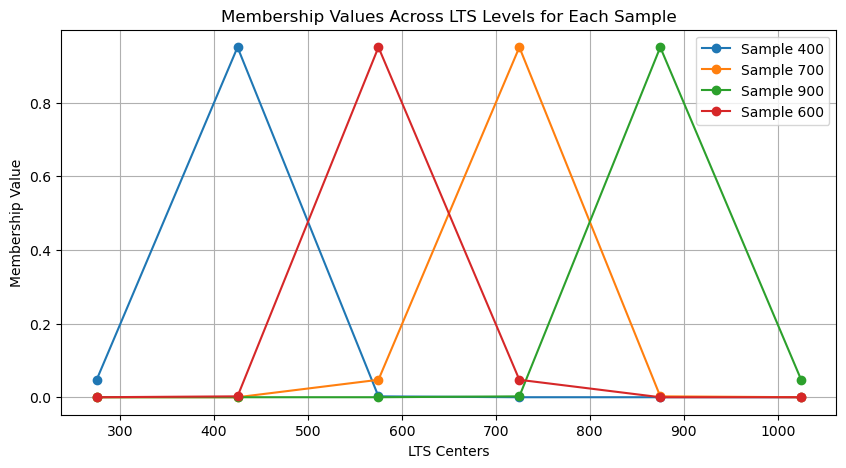

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# 样本数据
samples = np.array([400, 700, 900, 600])

# LTS级别定义，这里简化为中心点

# 假设整个评价的数值范围从0到600
value_range = np.linspace(np.min(samples) / 2, np.max(samples) + np.min(samples) / 2, 7)
lts_centers = (value_range[:-1] + value_range[1:]) / 2  # 计算每个区间的中心点

lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']



def gaussian_diffusion(x, mean, std_dev=50):
    """高斯扩散函数，mean为中心，std_dev为标准差控制扩散宽度"""
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

# 计算隶属度
def calculate_membership(samples, lts_centers, std_dev=50):
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        # 归一化，确保每个样本的隶属度和为1
        memberships[i, :] /= memberships[i, :].sum()
    return memberships

# 执行计算
memberships = calculate_membership(samples, lts_centers)

# 输出隶属度结果和PLTS评价
for i, sample in enumerate(samples):
    print(f"Sample {sample} memberships:")
    for lts_label, membership in zip(lts_labels, memberships[i]):
        print(f"  {lts_label}: {membership:.2f}")
    # 确定最大隶属度对应的LTS
    max_lts_index = np.argmax(memberships[i])
    print(f"Predicted PLTS for Sample {sample}: {lts_labels[max_lts_index]}\n")

# 可视化隶属度
plt.figure(figsize=(10, 5))
for i, sample in enumerate(samples):
    plt.plot(lts_centers, memberships[i], marker='o', label=f'Sample {sample}')
plt.xlabel('LTS Centers')
plt.ylabel('Membership Value')
plt.title('Membership Values Across LTS Levels for Each Sample')
plt.legend()
plt.grid(True)
plt.show()

Sample 400 memberships:
  s_-3: 0.26
  s_-2: 0.64
  s_-1: 0.10
  s0: 0.00
  s1: 0.00
  s2: 0.00
Predicted PLTS for Sample 400: s_-2

Sample 700 memberships:
  s_-3: 0.00
  s_-2: 0.01
  s_-1: 0.25
  s0: 0.64
  s1: 0.10
  s2: 0.00
Predicted PLTS for Sample 700: s0

Sample 900 memberships:
  s_-3: 0.00
  s_-2: 0.00
  s_-1: 0.00
  s0: 0.10
  s1: 0.64
  s2: 0.26
Predicted PLTS for Sample 900: s1

Sample 600 memberships:
  s_-3: 0.00
  s_-2: 0.10
  s_-1: 0.64
  s0: 0.25
  s1: 0.01
  s2: 0.00
Predicted PLTS for Sample 600: s_-1



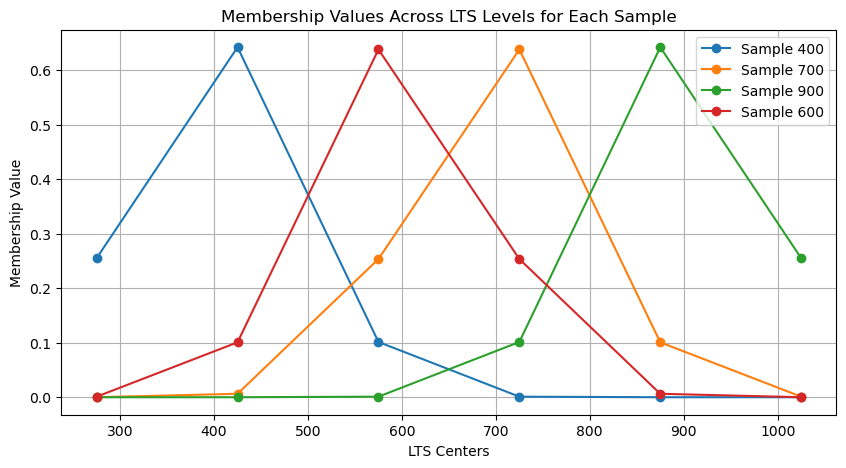

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 	1.	调整标准差（std_dev）：标准差控制了扩散的宽度，你可以根据样本数据的变异性来调整这个参数，以确保扩散函数能够适当地覆盖各个评价级别。例如，可以考虑使用样本标准差的一定比例作为标准差。
# 	2.	动态调整std_dev：你可以根据样本与中心点之间的距离动态调整std_dev，使得距离较远的样本对其它中心点的影响更小。
# 样本数据和动态确定LTS中心点
samples = np.array([400, 700, 900, 600])
value_range = np.linspace(np.min(samples) / 2, np.max(samples) + np.min(samples) / 2, 7)
lts_centers = (value_range[:-1] + value_range[1:]) / 2
lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']

def gaussian_diffusion(x, mean, std_dev):
    """高斯扩散函数"""
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev_ratio=0.5):
    """计算每个样本对各LTS级别的隶属度"""
    std_dev = np.std(samples) * std_dev_ratio  # 动态标准差
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()  # 归一化隶属度
    return memberships

memberships = calculate_membership(samples, lts_centers)

# 输出隶属度结果和PLTS评价
for i, sample in enumerate(samples):
    print(f"Sample {sample} memberships:")
    for lts_label, membership in zip(lts_labels, memberships[i]):
        print(f"  {lts_label}: {membership:.2f}")
    max_lts_index = np.argmax(memberships[i])
    print(f"Predicted PLTS for Sample {sample}: {lts_labels[max_lts_index]}\n")

# 可视化隶属度
plt.figure(figsize=(10, 5))
for i, sample in enumerate(samples):
    plt.plot(lts_centers, memberships[i], marker='o', label=f'Sample {sample}')
plt.xlabel('LTS Centers')
plt.ylabel('Membership Value')
plt.title('Membership Values Across LTS Levels for Each Sample')
plt.legend()
plt.grid(True)
plt.show()

PLTS Probabilities: {'s-3': 0.0033, 's-2': 0.0215, 's-1': 0.125, 's0': 0.3439, 's1': 0.352, 's2': 0.1263, 's3': 0.025, 's4': 0.0026}


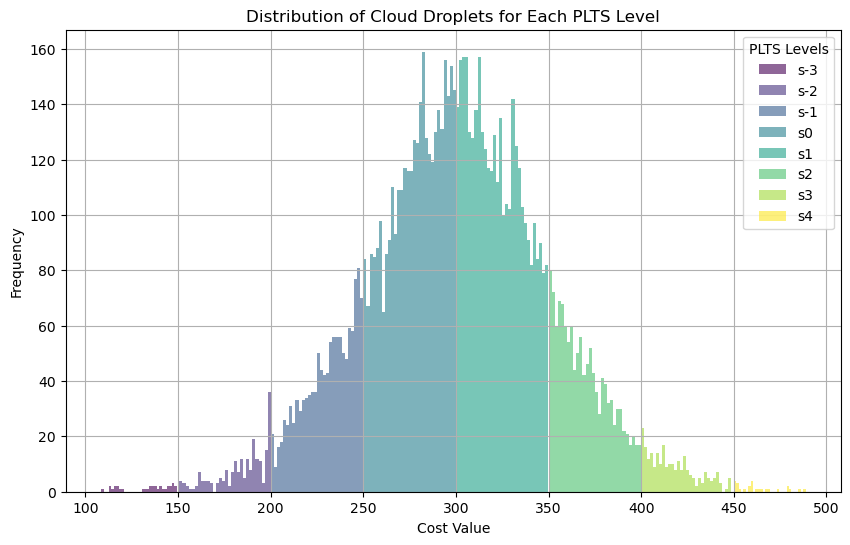

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def generate_cloud_droplets(Ex, En, He, num_droplets=10000):
    """根据云模型的期望、熵和超熵生成云滴"""
    entropies = np.random.normal(En, He, num_droplets)  # 熵的波动
    droplets = np.array([np.random.normal(Ex, entropy) for entropy in entropies])
    return droplets

def calculate_plts(droplets, thresholds):
    """计算每个区间的PLTS概率"""
    plts = {f"s{i-3}": 0 for i in range(len(thresholds)-1)}
    total_droplets = len(droplets)
    for droplet in droplets:
        for i, threshold in enumerate(thresholds[:-1]):
            if threshold <= droplet < thresholds[i+1]:
                plts[f"s{i-3}"] += 1
                break
    for key in plts:
        plts[key] /= total_droplets
    return plts

def plot_clouds(droplets, thresholds):
    """绘制每个PLTS级别的云图"""
    colors = plt.cm.viridis(np.linspace(0, 1, len(thresholds)-1))
    plt.figure(figsize=(10, 6))
    plt.title('Distribution of Cloud Droplets for Each PLTS Level')
    plt.xlabel('Cost Value')
    plt.ylabel('Frequency')
    
    for i, threshold in enumerate(thresholds[:-1]):
        data = droplets[(threshold <= droplets) & (droplets < thresholds[i+1])]
        plt.hist(data, bins=30, color=colors[i], alpha=0.6, label=f"s{i-3}")
    
    plt.legend(title='PLTS Levels')
    plt.grid(True)
    plt.show()

# 示例参数和执行
Ex = 300  # 期望成本
En = 50   # 熵设定
He = 10   # 超熵设定
num_droplets = 10000  # 生成的云滴数量
thresholds = [100, 150, 200, 250, 300, 350, 400, 450, 500]  # 阈值

# 生成云滴
droplets = generate_cloud_droplets(Ex, En, He, num_droplets)

# 计算PLTS概率
plts = calculate_plts(droplets, thresholds)
print("PLTS Probabilities:", plts)

# 绘制云图
plot_clouds(droplets, thresholds)

In [29]:
import numpy as np

def generate_cloud_droplets(Ex, En, He, num_droplets=1000):
    # Generate droplets
    droplets = np.random.normal(Ex, En, num_droplets)
    plts = {"s-3": 0, "s-2": 0, "s-1": 0, "s0": 0, "s1": 0, "s2": 0, "s3": 0}
    thresholds = [100, 150, 200, 250, 300, 350, 400, 450, 500]  # Example thresholds for PLTS levels

    # Map droplets to PLTS levels
    for droplet in droplets:
        for i in range(len(thresholds)-1):
            if thresholds[i] <= droplet < thresholds[i+1]:
                plts[f"s{i-3}"] += 1
                break

    # Normalize probabilities
    for key in plts:
        plts[key] /= num_droplets

    return plts

# Example usage
Ex = 300  # Expected cost
En = 50   # Entropy (standard deviation)
He = 10   # Hyper-entropy (not used in this simple model)
plts = generate_cloud_droplets(Ex, En, He)
print(plts)

{'s-3': 0.002, 's-2': 0.019, 's-1': 0.139, 's0': 0.33, 's1': 0.341, 's2': 0.145, 's3': 0.024}


Sample 400 memberships:
  s_-3: 0.02
  s_-2: 0.93
  s_-1: 0.05
  s0: 0.00
  s1: 0.00
  s2: 0.00
  s_3: 0.00
Predicted PLTS for Sample 400: s_-2

Sample 700 memberships:
  s_-3: 0.00
  s_-2: 0.00
  s_-1: 0.00
  s0: 0.67
  s1: 0.32
  s2: 0.00
  s_3: 0.00
Predicted PLTS for Sample 700: s0

Sample 900 memberships:
  s_-3: 0.00
  s_-2: 0.00
  s_-1: 0.00
  s0: 0.00
  s1: 0.05
  s2: 0.93
  s_3: 0.02
Predicted PLTS for Sample 900: s2

Sample 600 memberships:
  s_-3: 0.00
  s_-2: 0.00
  s_-1: 0.32
  s0: 0.67
  s1: 0.00
  s2: 0.00
  s_3: 0.00
Predicted PLTS for Sample 600: s0



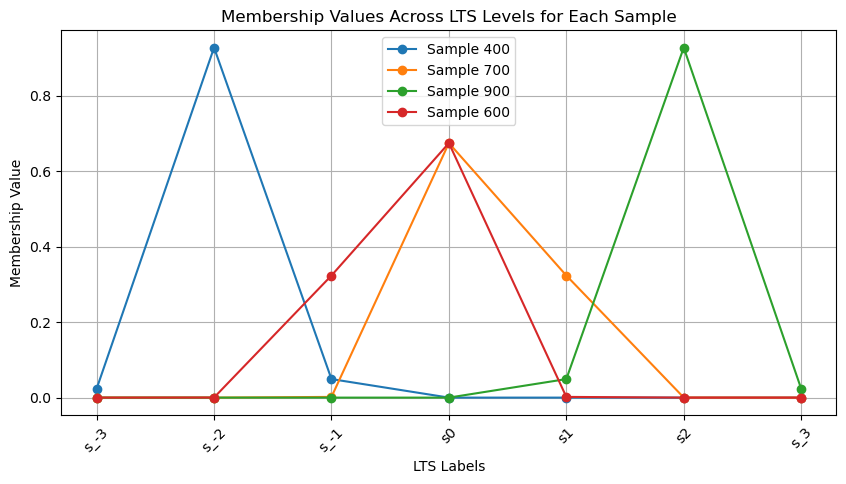

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 样本数据
samples = np.array([400, 700, 900, 600])

# 确保lts_labels与计算出的lts_centers数量一致
lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']
num_labels = len(lts_labels)

# 动态计算LTS中心点
value_range = np.linspace(np.min(samples) / 2, np.max(samples) + np.min(samples) / 2, num_labels + 1)  # 生成点的数量比标签多一个
lts_centers = (value_range[:-1] + value_range[1:]) / 2  # 计算每个区间的中心点

def gaussian_diffusion(x, mean, std_dev=50):
    """高斯扩散函数，mean为中心，std_dev为标准差控制扩散宽度"""
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev=50):
    """计算每个样本对各LTS级别的隶属度"""
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()
    return memberships

memberships = calculate_membership(samples, lts_centers)

# 输出隶属度结果和PLTS评价
for i, sample in enumerate(samples):
    print(f"Sample {sample} memberships:")
    for lts_label, membership in zip(lts_labels, memberships[i]):
        print(f"  {lts_label}: {membership:.2f}")
    max_lts_index = np.argmax(memberships[i])
    print(f"Predicted PLTS for Sample {sample}: {lts_labels[max_lts_index]}\n")

# 可视化隶属度
plt.figure(figsize=(10, 5))
for i, sample in enumerate(samples):
    plt.plot(lts_labels, memberships[i], marker='o', label=f'Sample {sample}')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.title('Membership Values Across LTS Levels for Each Sample')
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.legend()
plt.grid(True)
plt.show()

## 信息扩散生成PLTS

### 中心点采用生成区间的中点

Sample 400 PLTS memberships:
  s_-3: 0.079
  s_-2: 0.890
  s_-1: 0.031
  s0: 0.000
  s1: 0.000
  s2: 0.000
  s_3: 0.000
PLTS Result for Sample 400: s_-3: 0.079; s_-2: 0.890; s_-1: 0.031; s0: 0.000; s1: 0.000; s2: 0.000; s_3: 0.000

Sample 700 PLTS memberships:
  s_-3: 0.000
  s_-2: 0.000
  s_-1: 0.003
  s0: 0.617
  s1: 0.380
  s2: 0.001
  s_3: 0.000
PLTS Result for Sample 700: s_-3: 0.000; s_-2: 0.000; s_-1: 0.003; s0: 0.617; s1: 0.380; s2: 0.001; s_3: 0.000

Sample 900 PLTS memberships:
  s_-3: 0.000
  s_-2: 0.000
  s_-1: 0.000
  s0: 0.000
  s1: 0.031
  s2: 0.890
  s_3: 0.079
PLTS Result for Sample 900: s_-3: 0.000; s_-2: 0.000; s_-1: 0.000; s0: 0.000; s1: 0.031; s2: 0.890; s_3: 0.079

Sample 600 PLTS memberships:
  s_-3: 0.000
  s_-2: 0.001
  s_-1: 0.380
  s0: 0.617
  s1: 0.003
  s2: 0.000
  s_3: 0.000
PLTS Result for Sample 600: s_-3: 0.000; s_-2: 0.001; s_-1: 0.380; s0: 0.617; s1: 0.003; s2: 0.000; s_3: 0.000



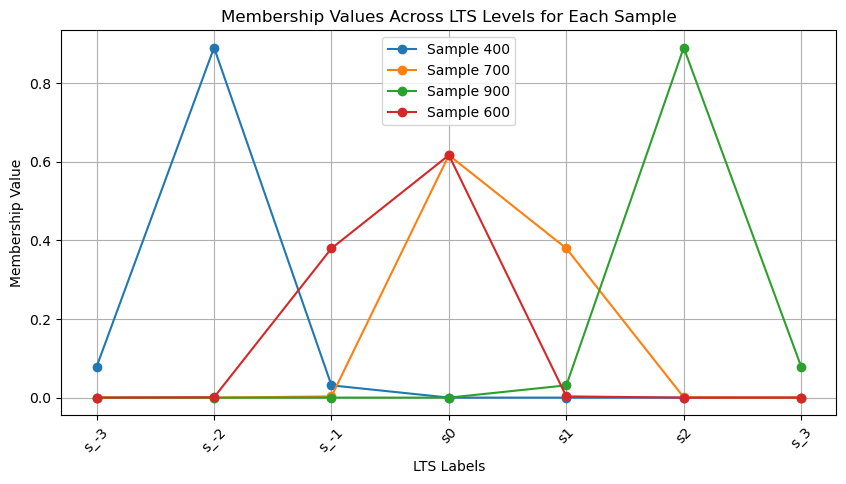

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# 样本数据
samples = np.array([400, 700, 900, 600])

# 计算样本的统计特征
sample_min = np.min(samples)
sample_max = np.max(samples)
sample_mean = np.mean(samples)
sample_std = np.std(samples)

# 设定边界，考虑从均值向两边扩展2个标准差
lower_bound = sample_mean - 2 * sample_std
upper_bound = sample_mean + 2 * sample_std

# 确保所有样本值被覆盖
lower_bound = min(lower_bound, sample_min)
upper_bound = max(upper_bound, sample_max)

# 生成LTS中心点
lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']
# Sol.1 
value_range = np.linspace(lower_bound, upper_bound, len(lts_labels) + 1) # 生成点的数量比标签多一个
lts_centers = (value_range[:-1] + value_range[1:]) / 2

# Sol. 2 直接使用生成的value_range作为中心点
lts_centers = np.linspace(lower_bound, upper_bound, len(lts_labels))  # 直接生成7个中心点


def gaussian_diffusion(x, mean, std_dev=50):
    """高斯扩散函数，用于计算隶属度"""
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev=50):
    """计算每个样本对每个LTS级别的隶属度，并归一化"""
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()
    return memberships

memberships = calculate_membership(samples, lts_centers)

# 输出隶属度结果和生成PLTS结果
for i, sample in enumerate(samples):
    print(f"Sample {sample} PLTS memberships:")
    plts_result = []
    for lts_label, membership in zip(lts_labels, memberships[i]):
        plts_result.append(f"{lts_label}: {membership:.3f}")
        print(f"  {lts_label}: {membership:.3f}")
    print(f"PLTS Result for Sample {sample}: {'; '.join(plts_result)}\n")

# 可视化隶属度
plt.figure(figsize=(10, 5))
for i, sample in enumerate(samples):
    plt.plot(lts_labels, memberships[i], marker='o', label=f'Sample {sample}')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.title('Membership Values Across LTS Levels for Each Sample')
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.legend()
plt.grid(True)
plt.show()

### 中心点直接使用生成的value_range

Sample 400 PLTS memberships:
  s_-3: 0.418
  s_-2: 0.571
  s_-1: 0.011
  s0: 0.000
  s1: 0.000
  s2: 0.000
  s_3: 0.000
PLTS Result for Sample 400: s_-3: 0.418; s_-2: 0.571; s_-1: 0.011; s0: 0.000; s1: 0.000; s2: 0.000; s_3: 0.000

Sample 700 PLTS memberships:
  s_-3: 0.000
  s_-2: 0.000
  s_-1: 0.008
  s0: 0.508
  s1: 0.478
  s2: 0.006
  s_3: 0.000
PLTS Result for Sample 700: s_-3: 0.000; s_-2: 0.000; s_-1: 0.008; s0: 0.508; s1: 0.478; s2: 0.006; s_3: 0.000

Sample 900 PLTS memberships:
  s_-3: 0.000
  s_-2: 0.000
  s_-1: 0.000
  s0: 0.000
  s1: 0.011
  s2: 0.571
  s_3: 0.418
PLTS Result for Sample 900: s_-3: 0.000; s_-2: 0.000; s_-1: 0.000; s0: 0.000; s1: 0.011; s2: 0.571; s_3: 0.418

Sample 600 PLTS memberships:
  s_-3: 0.000
  s_-2: 0.006
  s_-1: 0.478
  s0: 0.508
  s1: 0.008
  s2: 0.000
  s_3: 0.000
PLTS Result for Sample 600: s_-3: 0.000; s_-2: 0.006; s_-1: 0.478; s0: 0.508; s1: 0.008; s2: 0.000; s_3: 0.000



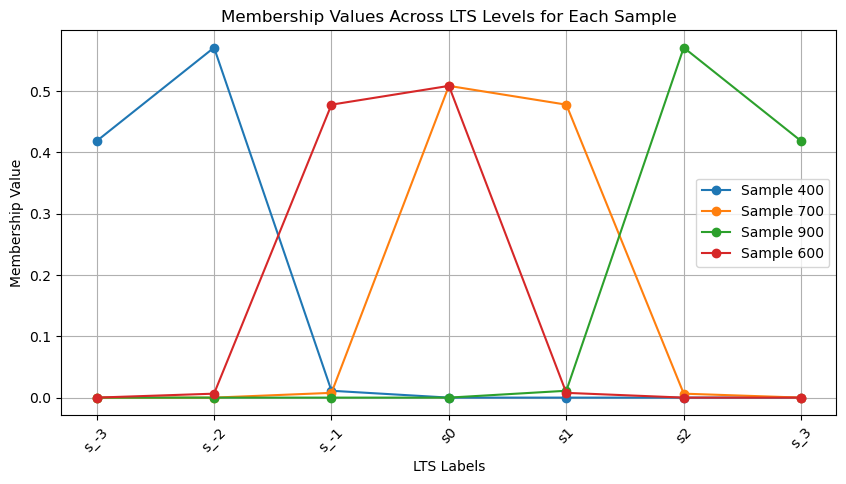

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# 样本数据
samples = np.array([400, 700, 900, 600])

# 计算样本的统计特征
sample_min = np.min(samples)
sample_max = np.max(samples)
sample_mean = np.mean(samples)
sample_std = np.std(samples)

# 设定边界，考虑从均值向两边扩展2个标准差
lower_bound = sample_mean - 2 * sample_std
upper_bound = sample_mean + 2 * sample_std

# 确保所有样本值被覆盖
lower_bound = min(lower_bound, sample_min)
upper_bound = max(upper_bound, sample_max)

# 生成LTS中心点
lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']
# Sol.1 
value_range = np.linspace(lower_bound, upper_bound, len(lts_labels) + 1) # 生成点的数量比标签多一个
lts_centers = (value_range[:-1] + value_range[1:]) / 2

# Sol. 2 直接使用生成的value_range作为中心点
# lts_centers = np.linspace(lower_bound, upper_bound, len(lts_labels))  # 直接生成7个中心点


def gaussian_diffusion(x, mean, std_dev=50):
    """高斯扩散函数，用于计算隶属度"""
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev=50):
    """计算每个样本对每个LTS级别的隶属度，并归一化"""
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()
    return memberships

memberships = calculate_membership(samples, lts_centers)

# 输出隶属度结果和生成PLTS结果
for i, sample in enumerate(samples):
    print(f"Sample {sample} PLTS memberships:")
    plts_result = []
    for lts_label, membership in zip(lts_labels, memberships[i]):
        plts_result.append(f"{lts_label}: {membership:.3f}")
        print(f"  {lts_label}: {membership:.3f}")
    print(f"PLTS Result for Sample {sample}: {'; '.join(plts_result)}\n")

# 可视化隶属度
plt.figure(figsize=(10, 5))
for i, sample in enumerate(samples):
    plt.plot(lts_labels, memberships[i], marker='o', label=f'Sample {sample}')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.title('Membership Values Across LTS Levels for Each Sample')
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.legend()
plt.grid(True)
plt.show()

### 两种方案对比

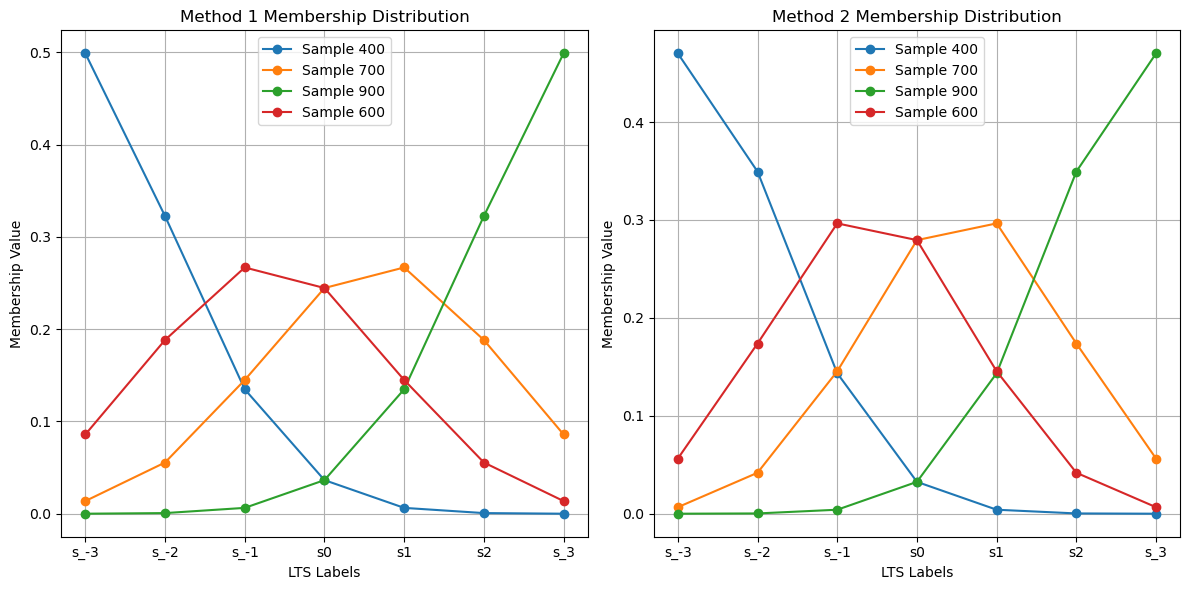

Method 1 PLTS Results:
Sample 400: {'s_-3': 0.5, 's_-2': 0.32, 's_-1': 0.13, 's0': 0.04, 's1': 0.01, 's2': 0.0, 's_3': 0.0}
Sample 700: {'s_-3': 0.01, 's_-2': 0.06, 's_-1': 0.14, 's0': 0.24, 's1': 0.27, 's2': 0.19, 's_3': 0.09}
Sample 900: {'s_-3': 0.0, 's_-2': 0.0, 's_-1': 0.01, 's0': 0.04, 's1': 0.13, 's2': 0.32, 's_3': 0.5}
Sample 600: {'s_-3': 0.09, 's_-2': 0.19, 's_-1': 0.27, 's0': 0.24, 's1': 0.14, 's2': 0.06, 's_3': 0.01}

Method 2 PLTS Results:
Sample 400: {'s_-3': 0.47, 's_-2': 0.35, 's_-1': 0.14, 's0': 0.03, 's1': 0.0, 's2': 0.0, 's_3': 0.0}
Sample 700: {'s_-3': 0.01, 's_-2': 0.04, 's_-1': 0.15, 's0': 0.28, 's1': 0.3, 's2': 0.17, 's_3': 0.06}
Sample 900: {'s_-3': 0.0, 's_-2': 0.0, 's_-1': 0.0, 's0': 0.03, 's1': 0.14, 's2': 0.35, 's_3': 0.47}
Sample 600: {'s_-3': 0.06, 's_-2': 0.17, 's_-1': 0.3, 's0': 0.28, 's1': 0.15, 's2': 0.04, 's_3': 0.01}


In [47]:
import numpy as np
import matplotlib.pyplot as plt

# 样本数据
samples = np.array([400, 700, 900, 600])

# 计算样本的统计特征
sample_min = np.min(samples)
sample_max = np.max(samples)
sample_std = np.std(samples)

# 动态标准差
std_dev_ratio = 0.6
std_dev = sample_std * std_dev_ratio  # 根据样本标准差计算动态标准差

# 两种方案的LTS中心点
value_range_method1 = np.linspace(sample_min, sample_max, 8)
lts_centers_method1 = (value_range_method1[:-1] + value_range_method1[1:]) / 2

value_range_method2 = np.linspace(sample_min, sample_max, 7)
lts_centers_method2 = value_range_method2

lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']

def gaussian_diffusion(x, mean, std_dev):
    """高斯扩散函数，用于计算隶属度"""
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev):
    """计算每个样本对每个LTS级别的隶属度，并归一化"""
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()
    return memberships

memberships_method1 = calculate_membership(samples, lts_centers_method1, std_dev)
memberships_method2 = calculate_membership(samples, lts_centers_method2, std_dev)

# 格式化PLTS输出，只保留非零隶属度
def format_plts_output(memberships, lts_labels):
    results = []
    for membership in memberships:
        result = {label: np.round(score, 2) for label, score in zip(lts_labels, membership) if score > 0}
        results.append(result)
    return results

plts_results_method1 = format_plts_output(memberships_method1, lts_labels)
plts_results_method2 = format_plts_output(memberships_method2, lts_labels)

# 可视化隶属度分布
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i, sample in enumerate(samples):
    plt.plot(lts_labels, memberships_method1[i], marker='o', label=f'Sample {sample}')
plt.title('Method 1 Membership Distribution')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i, sample in enumerate(samples):
    plt.plot(lts_labels, memberships_method2[i], marker='o', label=f'Sample {sample}')
plt.title('Method 2 Membership Distribution')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 输出PLTS结果
print("Method 1 PLTS Results:")
for i, result in enumerate(plts_results_method1):
    print(f"Sample {samples[i]}: {result}")

print("\nMethod 2 PLTS Results:")
for i, result in enumerate(plts_results_method2):
    print(f"Sample {samples[i]}: {result}")

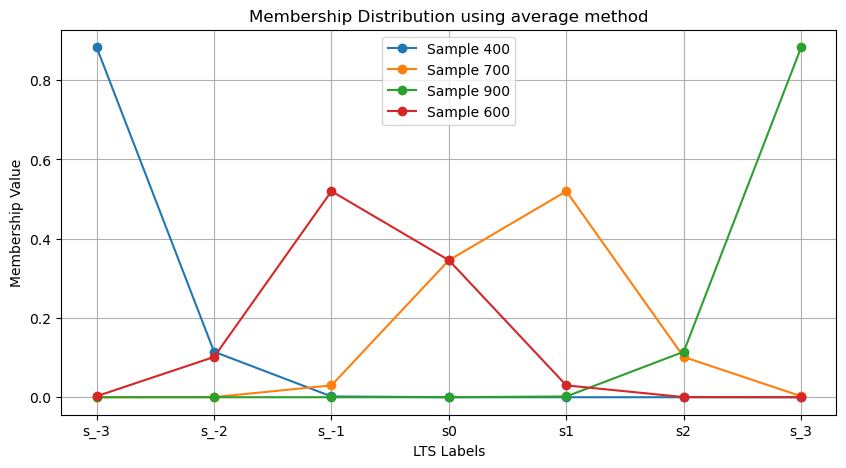

PLTS Results using average method:
Sample 400: {'s_-3': 0.88, 's_-2': 0.11, 's_-1': 0.0, 's0': 0.0, 's1': 0.0, 's2': 0.0, 's_3': 0.0}
Sample 700: {'s_-3': 0.0, 's_-2': 0.0, 's_-1': 0.03, 's0': 0.35, 's1': 0.52, 's2': 0.1, 's_3': 0.0}
Sample 900: {'s_-3': 0.0, 's_-2': 0.0, 's_-1': 0.0, 's0': 0.0, 's1': 0.0, 's2': 0.11, 's_3': 0.88}
Sample 600: {'s_-3': 0.0, 's_-2': 0.1, 's_-1': 0.52, 's0': 0.35, 's1': 0.03, 's2': 0.0, 's_3': 0.0}


In [48]:
### 合并算法
import numpy as np
import matplotlib.pyplot as plt

def generate_lts_centers(samples, method='average'):
    sample_min = np.min(samples)
    sample_max = np.max(samples)
    if method == 'average':
        value_range = np.linspace(sample_min, sample_max, 8)  # 生成8个点
        lts_centers = (value_range[:-1] + value_range[1:]) / 2  # 平均相邻值
    elif method == 'direct':
        lts_centers = np.linspace(sample_min, sample_max, 7)  # 直接生成7个中心点
    return lts_centers

def gaussian_diffusion(x, mean, std_dev=50):
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev=50):
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()  # 归一化隶属度
    return memberships

def format_plts_output(memberships, lts_labels):
    results = []
    for membership in memberships:
        result = {label: np.round(score, 2) for label, score in zip(lts_labels, membership) if score > 0}
        results.append(result)
    return results

# 样本数据
samples = np.array([400, 700, 900, 600])
lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']

# 选择方法
method_choice = 'average'  # 'average' or 'direct'

# 生成LTS中心点
lts_centers = generate_lts_centers(samples, method=method_choice)

# 计算隶属度
memberships = calculate_membership(samples, lts_centers, std_dev=50)

# 输出PLTS结果
plts_results = format_plts_output(memberships, lts_labels)

# 可视化隶属度分布
plt.figure(figsize=(10, 5))
for i, sample in enumerate(samples):
    plt.plot(lts_labels, memberships[i], marker='o', label=f'Sample {sample}')
plt.title(f'Membership Distribution using {method_choice} method')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.legend()
plt.grid(True)
plt.show()

# 输出每个样本的PLTS结果
print(f"PLTS Results using {method_choice} method:")
for i, result in enumerate(plts_results):
    print(f"Sample {samples[i]}: {result}")

### 合并算法

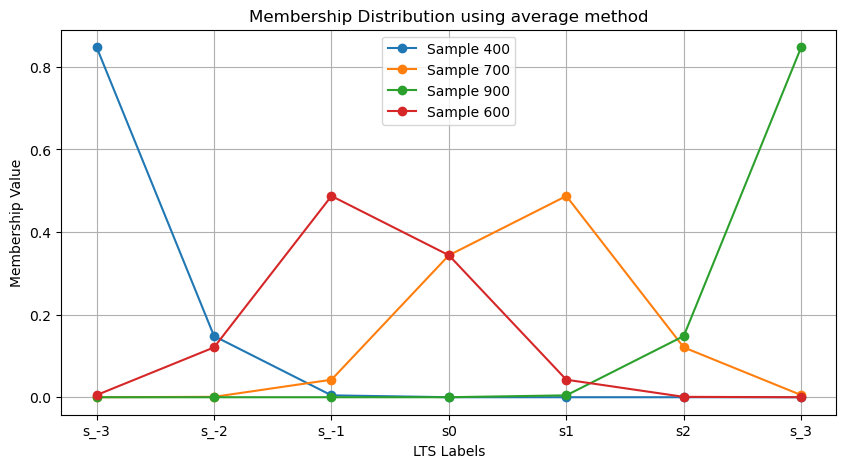

PLTS Results using average method with pruning threshold 0.01:
Sample 400: {'s_-3': 0.85, 's_-2': 0.15}
Sample 700: {'s_-1': 0.04, 's0': 0.35, 's1': 0.49, 's2': 0.12}
Sample 900: {'s2': 0.15, 's_3': 0.85}
Sample 600: {'s_-2': 0.12, 's_-1': 0.49, 's0': 0.35, 's1': 0.04}


In [61]:
import numpy as np
import matplotlib.pyplot as plt

def generate_lts_centers(samples, center_num,method='average'):
    sample_min = np.min(samples)
    sample_max = np.max(samples)
    if method == 'average':
        value_range = np.linspace(sample_min, sample_max, center_num+1)
        lts_centers = (value_range[:-1] + value_range[1:]) / 2
    elif method == 'direct':
        lts_centers = np.linspace(sample_min, sample_max, center_num)
    return lts_centers

def gaussian_diffusion(x, mean, std_dev):
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev):
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()
    return memberships

def format_plts_output(memberships, lts_labels, filter_zero=True):
    results = []
    for membership in memberships:
        if filter_zero:
            result = {label: np.round(score, 2) for label, score in zip(lts_labels, membership) if score > 1e-3}
        else:
            result = {label: np.round(score, 2) for label, score in zip(lts_labels, membership)}
        results.append(result)
    return results
# 剔除隶属度低于给定阈值的结果，并对剩余的隶属度进行归一化处理。对于小于0.01的隶属度信息实际应用中参考价值过低，考虑剔除。
def prune_and_normalize_memberships(memberships, lts_labels, threshold):
    pruned_results = []
    for membership in memberships:
        pruned = {label: score for label, score in zip(lts_labels, membership) if score > threshold}
        total = sum(pruned.values())
        normalized = {label: np.round(score / total, 2) for label, score in pruned.items()}
        pruned_results.append(normalized)
    return pruned_results

# 样本数据和设置
samples = np.array([400, 700, 900, 600])
lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']
std_dev_ratio = 0.3  # Ratio to calculate dynamic std_dev
#常见的 std_dev_ratio 范围从 0.1 到 1，具体取决于数据的分布和分析需求。
# •	较小的比例（0.1 - 0.3）：适用于希望扩散效果较细腻，隶属度函数较尖锐的场景，有助于突出数据点之间的差异。
# •	较大的比例（0.5 - 1）：适用于需要较宽扩散覆盖，隶属度函数较平滑的场景，有助于平滑数据的随机波动，适用于数据点较为稀疏或分布较广的情况。
sample_std = np.std(samples)
std_dev = sample_std * std_dev_ratio
prune_threshold = 0.01  # 隶属度小于此值的将被剔除

# 用户选择
method_choice = 'average'  # 'average' or 'direct'
output_filter_zero = True  # True to filter zero memberships, False to show all

# 生成LTS中心点
center_num = len(lts_labels)
lts_centers = generate_lts_centers(samples,center_num, method=method_choice)

# 计算隶属度
memberships = calculate_membership(samples, lts_centers, std_dev)

# 格式化PLTS输出
plts_results = format_plts_output(memberships, lts_labels, filter_zero=output_filter_zero)

# 剪裁和归一化隶属度
pruned_plts = prune_and_normalize_memberships(memberships, lts_labels, prune_threshold)


# 可视化隶属度分布
plt.figure(figsize=(10, 5))
for i, sample in enumerate(samples):
    plt.plot(lts_labels, memberships[i], marker='o', label=f'Sample {sample}')
plt.title(f'Membership Distribution using {method_choice} method')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.legend()
plt.grid(True)
plt.show()

# 输出每个样本的PLTS结果
# print(f"PLTS Results using {method_choice} method with {'filtered' if output_filter_zero else 'full'} output:")
# for i, result in enumerate(plts_results):
#     print(f"Sample {samples[i]}: {result}")
# 输出裁剪后的PLTS结果
print(f"PLTS Results using {method_choice} method with pruning threshold {prune_threshold}:")
for i, result in enumerate(pruned_plts):
    print(f"Sample {samples[i]}: {result}")